<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S9%5CS9-T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from results import plot_misclassified_images, plot_graph
from utilities import *
from data_engine import DataEngine
from gradcam.visualize import VisualizeCam
#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 35,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer


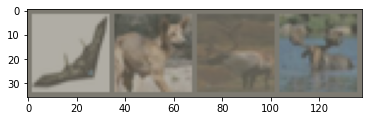

In [3]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))





In [4]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
scheduler = OneCycleLR(optimizer, max_lr=args.max_lr, epochs=args.epochs,
                       steps_per_epoch=len(data.train_loader))

def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc > 85.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs



Let us show some of the training images, for fun.



In [6]:
# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=455.77984619140625 L1_loss=108446.0625 Loss=1.9023112058639526 Batch_id=781 Accuracy=46.84: 100%|██████████| 782/782 [00:39<00:00, 19.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 5733/10000 (57.33%)

EPOCH: 2


L2_loss=450.5325012207031 L1_loss=106861.90625 Loss=2.23153018951416 Batch_id=781 Accuracy=66.45: 100%|██████████| 782/782 [00:40<00:00, 19.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0137, Accuracy: 6972/10000 (69.72%)

EPOCH: 3


L2_loss=441.9600830078125 L1_loss=104416.71875 Loss=1.3540637493133545 Batch_id=781 Accuracy=74.57: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0110, Accuracy: 7545/10000 (75.45%)

EPOCH: 4


L2_loss=430.09796142578125 L1_loss=101137.3671875 Loss=1.208504557609558 Batch_id=781 Accuracy=79.32: 100%|██████████| 782/782 [00:40<00:00, 19.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0122, Accuracy: 7443/10000 (74.43%)

EPOCH: 5


L2_loss=415.8902282714844 L1_loss=97308.609375 Loss=1.2862545251846313 Batch_id=781 Accuracy=82.14: 100%|██████████| 782/782 [00:40<00:00, 19.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0123, Accuracy: 7464/10000 (74.64%)

EPOCH: 6


L2_loss=400.2153625488281 L1_loss=93150.0 Loss=1.1732752323150635 Batch_id=781 Accuracy=84.31: 100%|██████████| 782/782 [00:40<00:00, 19.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 7603/10000 (76.03%)

EPOCH: 7


L2_loss=383.7031555175781 L1_loss=88846.5390625 Loss=1.353558897972107 Batch_id=781 Accuracy=86.35: 100%|██████████| 782/782 [00:40<00:00, 19.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 7837/10000 (78.37%)

EPOCH: 8


L2_loss=367.04693603515625 L1_loss=84593.4453125 Loss=1.2804440259933472 Batch_id=781 Accuracy=87.82: 100%|██████████| 782/782 [00:40<00:00, 19.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0115, Accuracy: 7792/10000 (77.92%)

EPOCH: 9


L2_loss=350.6361389160156 L1_loss=80491.25 Loss=1.2325479984283447 Batch_id=781 Accuracy=88.85: 100%|██████████| 782/782 [00:40<00:00, 19.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0089, Accuracy: 8129/10000 (81.29%)

EPOCH: 10


L2_loss=334.87078857421875 L1_loss=76643.53125 Loss=0.6910146474838257 Batch_id=781 Accuracy=90.13: 100%|██████████| 782/782 [00:40<00:00, 19.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0086, Accuracy: 8267/10000 (82.67%)

EPOCH: 11


L2_loss=319.7754211425781 L1_loss=72992.125 Loss=0.5799252390861511 Batch_id=781 Accuracy=91.29: 100%|██████████| 782/782 [00:40<00:00, 19.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8273/10000 (82.73%)

EPOCH: 12


L2_loss=305.5907287597656 L1_loss=69673.6953125 Loss=1.001602292060852 Batch_id=781 Accuracy=91.93: 100%|██████████| 782/782 [00:40<00:00, 19.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 8307/10000 (83.07%)

EPOCH: 13


L2_loss=292.1558532714844 L1_loss=66570.6875 Loss=0.8752871751785278 Batch_id=781 Accuracy=92.84: 100%|██████████| 782/782 [00:41<00:00, 19.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8454/10000 (84.54%)

EPOCH: 14


L2_loss=279.6175842285156 L1_loss=63752.90234375 Loss=0.8674799799919128 Batch_id=781 Accuracy=93.46: 100%|██████████| 782/782 [00:40<00:00, 19.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8475/10000 (84.75%)

EPOCH: 15


L2_loss=268.16217041015625 L1_loss=61243.66796875 Loss=0.6026967167854309 Batch_id=781 Accuracy=93.84: 100%|██████████| 782/782 [00:41<00:00, 18.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 97 %
Accuracy of  bird : 80 %
Accuracy of   cat : 80 %
Accuracy of  deer : 89 %
Accuracy of   dog : 75 %
Accuracy of  frog : 94 %
Accuracy of horse : 82 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0071, Accuracy: 8585/10000 (85.85%)

EPOCH: 16


L2_loss=257.25701904296875 L1_loss=58895.05859375 Loss=0.9113191962242126 Batch_id=781 Accuracy=94.29: 100%|██████████| 782/782 [00:40<00:00, 19.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0086, Accuracy: 8340/10000 (83.40%)

EPOCH: 17


L2_loss=247.12747192382812 L1_loss=56763.23828125 Loss=0.6161795854568481 Batch_id=781 Accuracy=94.79: 100%|██████████| 782/782 [00:41<00:00, 18.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 98 %
Accuracy of  bird : 87 %
Accuracy of   cat : 80 %
Accuracy of  deer : 88 %
Accuracy of   dog : 84 %
Accuracy of  frog : 94 %
Accuracy of horse : 95 %
Accuracy of  ship : 90 %
Accuracy of truck : 87 %

Test set: Average loss: 0.0065, Accuracy: 8642/10000 (86.42%)

EPOCH: 18


L2_loss=237.47975158691406 L1_loss=54690.23046875 Loss=0.4557470679283142 Batch_id=781 Accuracy=95.41: 100%|██████████| 782/782 [00:42<00:00, 18.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 89 %
Accuracy of  bird : 81 %
Accuracy of   cat : 80 %
Accuracy of  deer : 91 %
Accuracy of   dog : 71 %
Accuracy of  frog : 95 %
Accuracy of horse : 92 %
Accuracy of  ship : 92 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0074, Accuracy: 8559/10000 (85.59%)

EPOCH: 19


L2_loss=228.60557556152344 L1_loss=52803.7109375 Loss=0.46452897787094116 Batch_id=781 Accuracy=95.68: 100%|██████████| 782/782 [00:41<00:00, 18.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 100 %
Accuracy of  bird : 67 %
Accuracy of   cat : 68 %
Accuracy of  deer : 77 %
Accuracy of   dog : 70 %
Accuracy of  frog : 79 %
Accuracy of horse : 94 %
Accuracy of  ship : 85 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0073, Accuracy: 8584/10000 (85.84%)

EPOCH: 20


L2_loss=220.09298706054688 L1_loss=50942.46875 Loss=0.9770117998123169 Batch_id=781 Accuracy=96.35: 100%|██████████| 782/782 [00:41<00:00, 19.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 77 %
Accuracy of   cat : 77 %
Accuracy of  deer : 81 %
Accuracy of   dog : 76 %
Accuracy of  frog : 90 %
Accuracy of horse : 92 %
Accuracy of  ship : 92 %
Accuracy of truck : 85 %

Test set: Average loss: 0.0069, Accuracy: 8682/10000 (86.82%)

EPOCH: 21


L2_loss=212.46800231933594 L1_loss=49364.3046875 Loss=0.46440553665161133 Batch_id=781 Accuracy=96.42: 100%|██████████| 782/782 [00:40<00:00, 19.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 90 %
Accuracy of  bird : 83 %
Accuracy of   cat : 66 %
Accuracy of  deer : 90 %
Accuracy of   dog : 72 %
Accuracy of  frog : 83 %
Accuracy of horse : 95 %
Accuracy of  ship : 86 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0066, Accuracy: 8714/10000 (87.14%)

EPOCH: 22


L2_loss=204.99264526367188 L1_loss=47698.71484375 Loss=0.6596181988716125 Batch_id=781 Accuracy=97.02: 100%|██████████| 782/782 [00:40<00:00, 19.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 83 %
Accuracy of  bird : 87 %
Accuracy of   cat : 91 %
Accuracy of  deer : 96 %
Accuracy of   dog : 81 %
Accuracy of  frog : 89 %
Accuracy of horse : 91 %
Accuracy of  ship : 89 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0073, Accuracy: 8590/10000 (85.90%)

EPOCH: 23


L2_loss=198.28521728515625 L1_loss=46216.88671875 Loss=0.3963404893875122 Batch_id=781 Accuracy=97.28: 100%|██████████| 782/782 [00:40<00:00, 19.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 94 %
Accuracy of  bird : 79 %
Accuracy of   cat : 88 %
Accuracy of  deer : 87 %
Accuracy of   dog : 64 %
Accuracy of  frog : 84 %
Accuracy of horse : 96 %
Accuracy of  ship : 89 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0072, Accuracy: 8618/10000 (86.18%)

EPOCH: 24


L2_loss=191.78233337402344 L1_loss=44692.06640625 Loss=0.4706374406814575 Batch_id=781 Accuracy=97.73: 100%|██████████| 782/782 [00:41<00:00, 18.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 78 %
Accuracy of   car : 91 %
Accuracy of  bird : 86 %
Accuracy of   cat : 74 %
Accuracy of  deer : 75 %
Accuracy of   dog : 76 %
Accuracy of  frog : 93 %
Accuracy of horse : 100 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0066, Accuracy: 8732/10000 (87.32%)

EPOCH: 25


L2_loss=185.54367065429688 L1_loss=43124.9765625 Loss=0.3736264109611511 Batch_id=781 Accuracy=98.25: 100%|██████████| 782/782 [00:41<00:00, 19.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 90 %
Accuracy of   cat : 77 %
Accuracy of  deer : 97 %
Accuracy of   dog : 88 %
Accuracy of  frog : 88 %
Accuracy of horse : 93 %
Accuracy of  ship : 98 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0062, Accuracy: 8843/10000 (88.43%)

EPOCH: 26


L2_loss=179.48960876464844 L1_loss=41500.5625 Loss=0.33406615257263184 Batch_id=781 Accuracy=98.79: 100%|██████████| 782/782 [00:41<00:00, 18.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 98 %
Accuracy of  bird : 90 %
Accuracy of   cat : 78 %
Accuracy of  deer : 96 %
Accuracy of   dog : 79 %
Accuracy of  frog : 93 %
Accuracy of horse : 87 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0062, Accuracy: 8836/10000 (88.36%)

EPOCH: 27


L2_loss=173.74415588378906 L1_loss=39873.046875 Loss=0.298073410987854 Batch_id=781 Accuracy=99.27: 100%|██████████| 782/782 [00:41<00:00, 18.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 95 %
Accuracy of  bird : 86 %
Accuracy of   cat : 84 %
Accuracy of  deer : 85 %
Accuracy of   dog : 79 %
Accuracy of  frog : 89 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0056, Accuracy: 8947/10000 (89.47%)

EPOCH: 28


L2_loss=168.53541564941406 L1_loss=38304.3671875 Loss=0.649876058101654 Batch_id=781 Accuracy=99.65: 100%|██████████| 782/782 [00:41<00:00, 19.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 91 %
Accuracy of  bird : 84 %
Accuracy of   cat : 72 %
Accuracy of  deer : 90 %
Accuracy of   dog : 80 %
Accuracy of  frog : 91 %
Accuracy of horse : 89 %
Accuracy of  ship : 96 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0052, Accuracy: 9021/10000 (90.21%)

EPOCH: 29


L2_loss=164.2009735107422 L1_loss=36988.21484375 Loss=0.28327640891075134 Batch_id=781 Accuracy=99.83: 100%|██████████| 782/782 [00:41<00:00, 18.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 95 %
Accuracy of  bird : 89 %
Accuracy of   cat : 78 %
Accuracy of  deer : 86 %
Accuracy of   dog : 79 %
Accuracy of  frog : 90 %
Accuracy of horse : 95 %
Accuracy of  ship : 95 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0051, Accuracy: 9019/10000 (90.19%)

EPOCH: 30


L2_loss=160.68568420410156 L1_loss=35885.78125 Loss=0.27050313353538513 Batch_id=781 Accuracy=99.96: 100%|██████████| 782/782 [00:41<00:00, 18.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 92 %
Accuracy of  bird : 86 %
Accuracy of   cat : 85 %
Accuracy of  deer : 92 %
Accuracy of   dog : 71 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 91 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0049, Accuracy: 9080/10000 (90.80%)

EPOCH: 31


L2_loss=158.14309692382812 L1_loss=35085.3671875 Loss=0.2640761137008667 Batch_id=781 Accuracy=99.99: 100%|██████████| 782/782 [00:41<00:00, 18.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 83 %
Accuracy of  deer : 94 %
Accuracy of   dog : 85 %
Accuracy of  frog : 96 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0047, Accuracy: 9107/10000 (91.07%)

EPOCH: 32


L2_loss=156.50711059570312 L1_loss=34569.6484375 Loss=0.2683776021003723 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:41<00:00, 18.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 95 %
Accuracy of  bird : 87 %
Accuracy of   cat : 77 %
Accuracy of  deer : 94 %
Accuracy of   dog : 85 %
Accuracy of  frog : 90 %
Accuracy of horse : 93 %
Accuracy of  ship : 90 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0045, Accuracy: 9139/10000 (91.39%)

EPOCH: 33


L2_loss=155.62701416015625 L1_loss=34292.60546875 Loss=0.2647791802883148 Batch_id=781 Accuracy=99.99: 100%|██████████| 782/782 [00:41<00:00, 18.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 98 %
Accuracy of  bird : 87 %
Accuracy of   cat : 86 %
Accuracy of  deer : 92 %
Accuracy of   dog : 88 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 97 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0046, Accuracy: 9118/10000 (91.18%)

EPOCH: 34


L2_loss=155.2913055419922 L1_loss=34186.93359375 Loss=0.27058786153793335 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:41<00:00, 18.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 100 %
Accuracy of  bird : 91 %
Accuracy of   cat : 85 %
Accuracy of  deer : 85 %
Accuracy of   dog : 88 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 93 %
Accuracy of truck : 98 %

Test set: Average loss: 0.0046, Accuracy: 9132/10000 (91.32%)

EPOCH: 35


L2_loss=155.2425537109375 L1_loss=34171.37109375 Loss=0.26338520646095276 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:41<00:00, 18.78it/s]



Accuracy of plane : 93 %
Accuracy of   car : 94 %
Accuracy of  bird : 86 %
Accuracy of   cat : 81 %
Accuracy of  deer : 85 %
Accuracy of   dog : 87 %
Accuracy of  frog : 100 %
Accuracy of horse : 94 %
Accuracy of  ship : 93 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0047, Accuracy: 9113/10000 (91.13%)



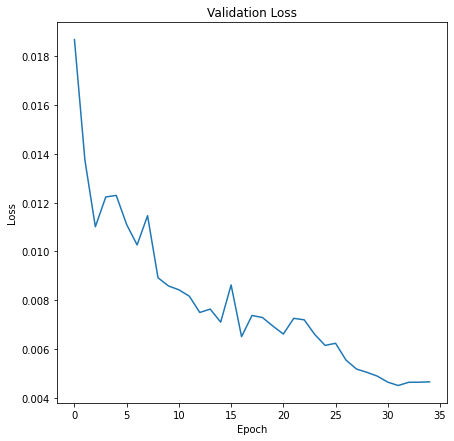

In [7]:
plot_graph(test_losses, "Loss")



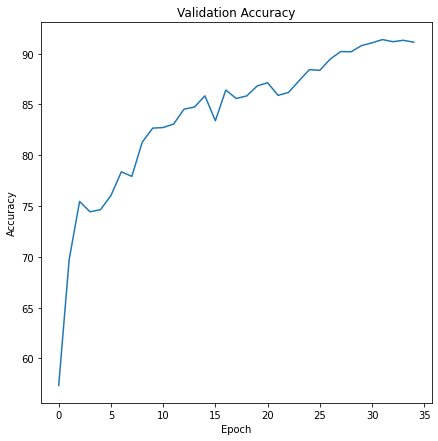

In [8]:
plot_graph(test_accs, "Accuracy")



In [0]:
plot_misclassified_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

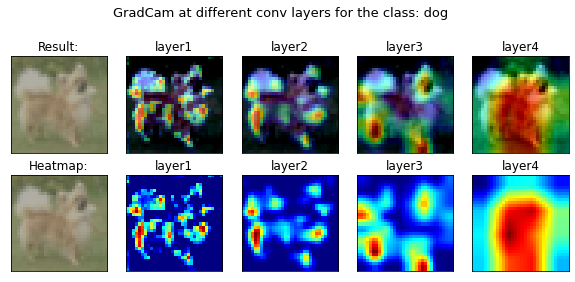

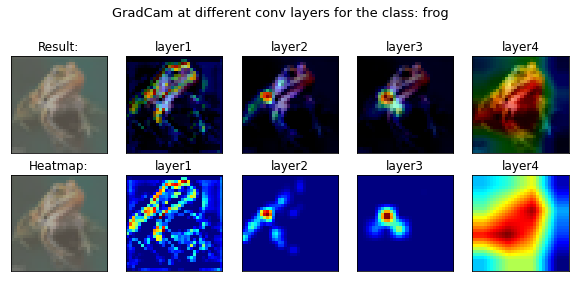

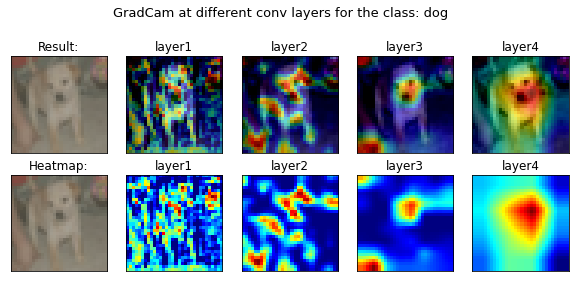

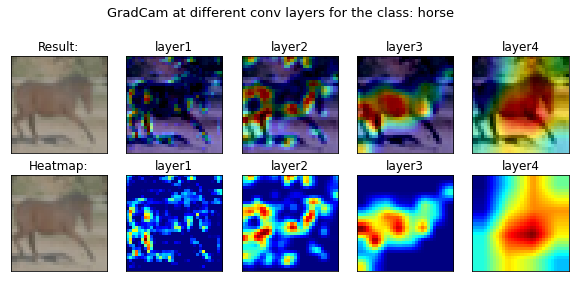

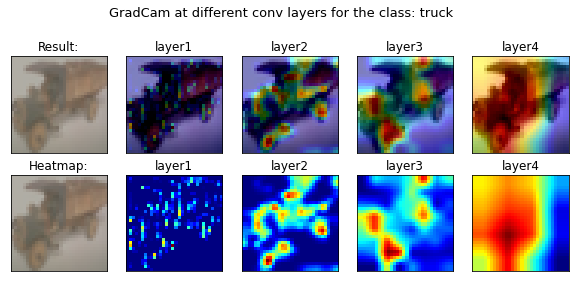

In [11]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

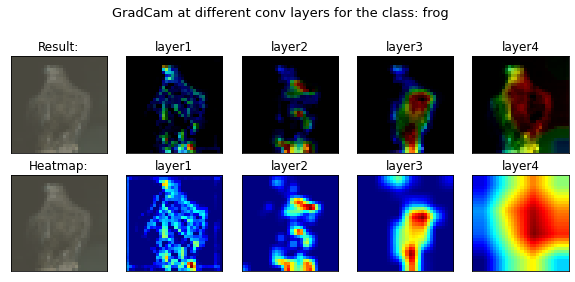

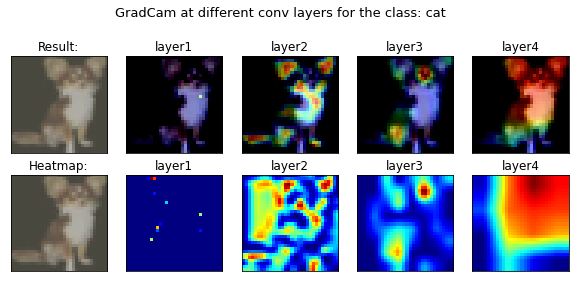

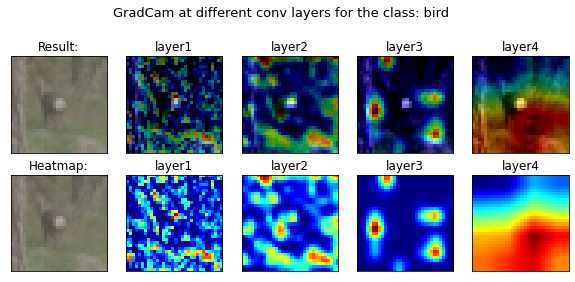

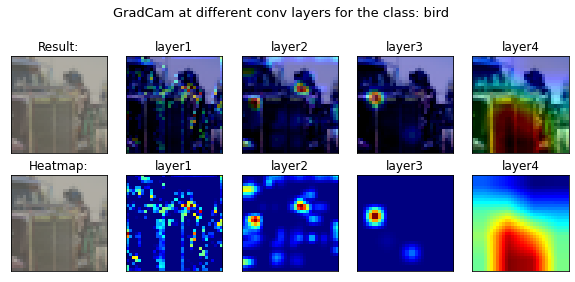

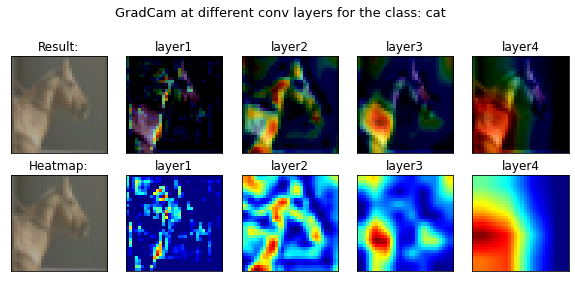

In [12]:
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")